In [1]:
import xarray as xr
import pandas as pd
import arraylake
# import hvplot.xarray
from arraylake import Client

## Connect to Arraylake and Open Dataset

In [3]:
session = repo.readonly_session('main')
ds = xr.open_zarr(session.store, zarr_format=3, consolidated=False, chunks=None)
ds.load()

c:\Users\bkrai\Source\venv-bklm\Lib\site-packages\zarr\codecs\vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.Dataset> Size: 195MB
Dimensions:       (ticker: 3057, time: 1139)
Coordinates:
  * ticker        (ticker) object 24kB 'A' 'AA' 'AACT' ... 'ZVIA' 'ZWS' 'BKRA'
  * time          (time) datetime64[ns] 9kB 2018-12-03T05:00:00 ... 2023-06-1...
Data variables:
    volume        (ticker, time) float64 28MB 4.266e+06 4.264e+06 ... 2.502e+06
    low           (ticker, time) float64 28MB 73.19 72.63 69.9 ... 115.8 118.7
    close         (ticker, time) float64 28MB 74.67 72.91 71.91 ... 118.5 119.5
    transactions  (ticker, time) float64 28MB 3.261e+04 3.503e+04 ... 4.036e+04
    vwap          (ticker, time) float64 28MB 74.35 73.81 71.28 ... 117.6 119.8
    open          (ticker, time) float64 28MB 73.33 74.7 71.2 ... 115.9 118.7
    high          (ticker, time) float64 28MB 74.79 75.11 71.93 ... 118.7 121.2

Also available at <https://app.earthmover.io/org/earthmover-demos/stocks/tree/main/NYSE/daily>

## Basic Data Exploration

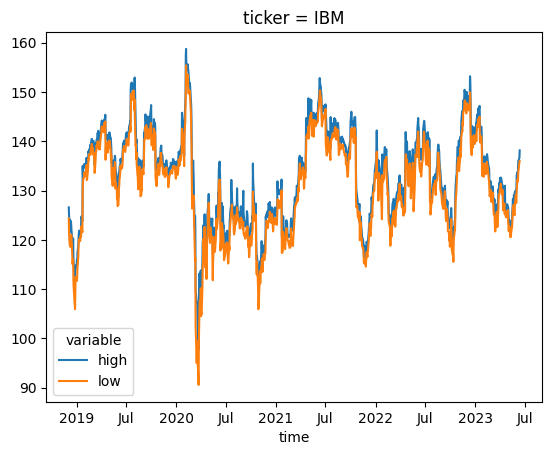

In [4]:
ds.sel(ticker="IBM")[['high', 'low']].to_dataarray().plot(hue="variable");

## Calculate Percent Return

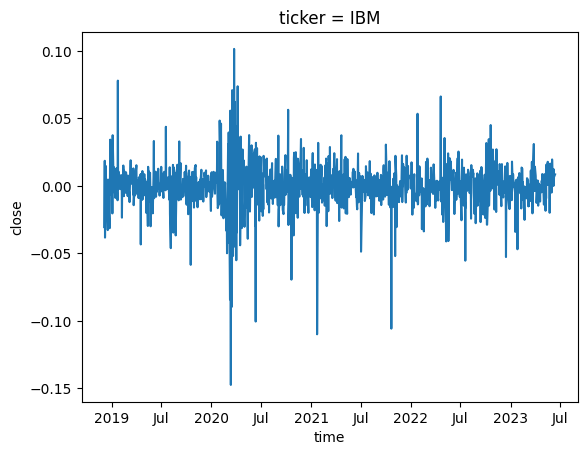

In [5]:
price = ds['close']
ret = price.diff('time') / price
ret.sel(ticker="IBM").plot()

## Calculate Volatility Metrics

We will use an exponentially weighted rolling standard deviation with different half lives.
This will take our data from 2D to 3D.

In [6]:
def get_volatility_set(da, halflifes):
    return xr.concat([da.rolling_exp({'time': h}, window_type='halflife').std()
                       for h in halflifes],
                       dim=pd.Index(halflifes, name='vol_type'))

halflifes = [21, 63, 126, 252, 512]

vol = get_volatility_set(price, halflifes)
vol

<xarray.DataArray 'close' (vol_type: 5, ticker: 3057, time: 1139)> Size: 139MB
array([[[           nan, 1.24450793e+00, 1.39307545e+00, ...,
         1.06067542e+01, 1.06193904e+01, 1.05902078e+01],
        [           nan, 1.16672619e+00, 1.22285342e+00, ...,
         5.13619605e+00, 5.08112530e+00, 5.00274711e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan, 7.07106781e-03],
        ...,
        [           nan,            nan,            nan, ...,
         3.91744570e-01, 4.17450100e-01, 4.37156365e-01],
        [           nan,            nan,            nan, ...,
         1.59434609e+00, 1.65926850e+00, 1.76328583e+00],
        [           nan, 1.24450793e+00, 1.39307545e+00, ...,
         1.06067542e+01, 1.06193904e+01, 1.05902078e+01]],

       [[           nan, 1.24450793e+00, 1.39594038e+00, ...,
         1.20505497e+01, 1.21227763e+01, 1.21763805e+01],
        [           nan, 1.16672619e+00, 1.22617762e+00, ...,
         9.06794730e+00, 9.06066592e+00, 9.03720310e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan, 7.07106782e-03],
...
        [           nan,            nan,            nan, ...,
         2.83010483e+00, 2.82490563e+00, 2.81973934e+00],
        [           nan,            nan,            nan, ...,
         5.22462596e+00, 5.21466354e+00, 5.20428983e+00],
        [           nan, 1.24450793e+00, 1.39698582e+00, ...,
         2.25509720e+01, 2.25281065e+01, 2.25037965e+01]],

       [[           nan, 1.24450793e+00, 1.39716122e+00, ...,
         2.77470266e+01, 2.77239291e+01, 2.77005829e+01],
        [           nan, 1.16672619e+00, 1.22760426e+00, ...,
         1.82117265e+01, 1.81968564e+01, 1.81814679e+01],
        [           nan,            nan,            nan, ...,
                    nan,            nan, 7.07106782e-03],
        ...,
        [           nan,            nan,            nan, ...,
         3.18321133e+00, 3.17900919e+00, 3.17484160e+00],
        [           nan,            nan,            nan, ...,
         5.42827932e+00, 5.42093573e+00, 5.41290624e+00],
        [           nan, 1.24450793e+00, 1.39716122e+00, ...,
         2.77470266e+01, 2.77239291e+01, 2.77005829e+01]]])
Coordinates:
  * ticker    (ticker) object 24kB 'A' 'AA' 'AACT' ... 'ZVIA' 'ZWS' 'BKRA'
  * time      (time) datetime64[ns] 9kB 2018-12-03T05:00:00 ... 2023-06-13T04...
  * vol_type  (vol_type) int64 40B 21 63 126 252 512

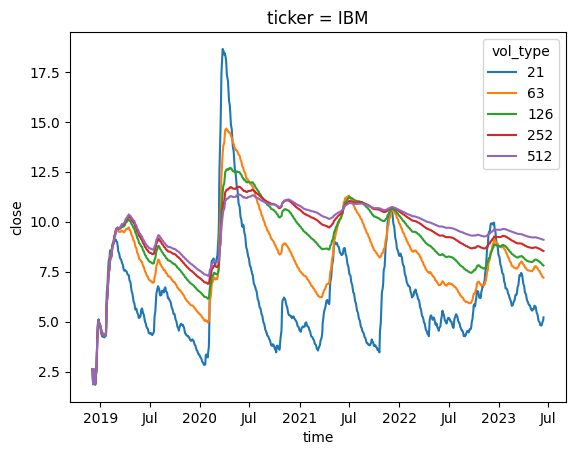

In [7]:
vol.sel(ticker="IBM").plot(hue="vol_type");

## Dimensionality Reduction: PCA

We will use principal component analysis to reduce the variability to a smaller number of factors.

In [8]:
from eofs.xarray import Eof
solver = Eof(ret.transpose())
pcs = solver.pcs(npcs=20).rename("factor")
pcs

<xarray.DataArray 'factor' (time: 1138, mode: 20)> Size: 182kB
array([[ 1.38543743e+00,  7.08168348e-02, -3.54485292e-01, ...,
        -2.55382350e-04, -2.75486083e-02,  7.78245184e-02],
       [ 2.31366512e-01, -4.19263656e-02, -1.04999568e-02, ...,
        -1.61230044e-01, -9.60240908e-02, -1.06218674e-02],
       [ 5.69439753e-01,  5.60716418e-02, -2.71823740e-01, ...,
        -4.93170685e-02,  2.59910940e-02, -1.39892963e-02],
       ...,
       [ 1.89811305e-01, -3.92954416e-02, -4.39120119e-02, ...,
         5.47287985e-02,  5.36824036e-02, -1.15698527e-02],
       [-6.96422173e-02, -1.28422557e-02,  7.71031403e-02, ...,
         4.47362804e-02, -5.77030286e-02,  5.33487651e-02],
       [-3.83092746e-01, -3.48814923e-02,  1.05233917e-01, ...,
        -1.93421668e-02,  2.63716657e-02, -2.80608287e-02]])
Coordinates:
  * time     (time) datetime64[ns] 9kB 2018-12-04T05:00:00 ... 2023-06-13T04:...
  * mode     (mode) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

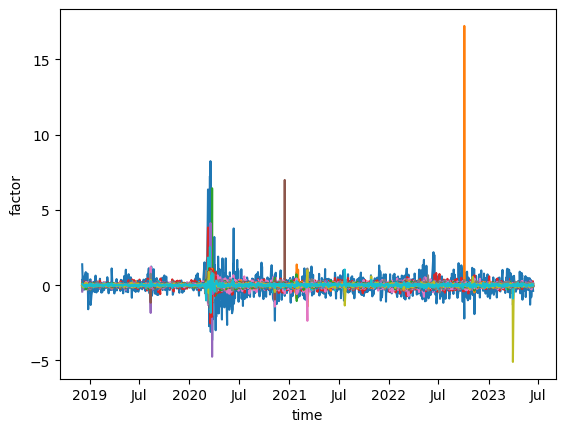

In [9]:
pcs.plot(hue="mode", add_legend=False);

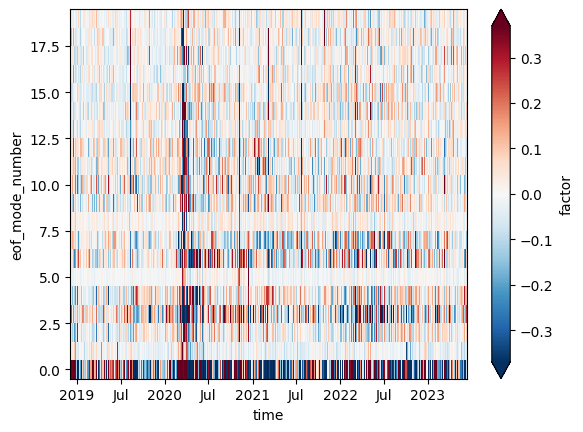

In [10]:
pcs.plot(x="time", robust=True);

## Cross Correlation Between Factors

We compute a rolling cross-correlation between the different factors.

In [11]:
def get_ewm_corr(ret, halflife):
    return (
        ret.to_pandas()
        .ewm(halflife=halflife)
        .corr()
        .stack()
        .rename_axis(['date', 'factor_1', 'factor_0'])
        .rename('corr')
        .to_xarray()
    )

def get_correlation_set(ret, halflifes):
    return xr.concat(
        [get_ewm_corr(ret, h) for h in halflifes],
        dim=pd.Index(halflifes, name='corr_type')
    )

corr = get_correlation_set(pcs, halflifes)
corr

<xarray.DataArray 'corr' (corr_type: 5, date: 1137, factor_1: 20, factor_0: 20)> Size: 18MB
array([[[[ 1.00000000e+00,  1.00000000e+00, -1.00000000e+00, ...,
           1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
         [ 1.00000000e+00,  1.00000000e+00, -1.00000000e+00, ...,
           1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
         [-1.00000000e+00, -1.00000000e+00,  1.00000000e+00, ...,
          -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
         ...,
         [ 1.00000000e+00,  1.00000000e+00, -1.00000000e+00, ...,
           1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
         [ 1.00000000e+00,  1.00000000e+00, -1.00000000e+00, ...,
           1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
         [ 1.00000000e+00,  1.00000000e+00, -1.00000000e+00, ...,
           1.00000000e+00,  1.00000000e+00,  1.00000000e+00]],

        [[ 1.00000000e+00,  7.98277976e-01, -8.60775351e-01, ...,
           8.94391842e-01,  3.46951459e-01,  9.46970594e-01],
         [ 7.98277976e-01,  1.00000000e+00, -9.93694209e-01, ...,
           9.83367802e-01,  8.41840558e-01,  5.62418061e-01],
         [-8.60775351e-01, -9.93694209e-01,  1.00000000e+00, ...,
          -9.97531473e-01, -7.76015747e-01, -6.51581743e-01],
...
         [ 2.72187378e-02,  1.09963187e-03, -1.31381621e-02, ...,
           1.00000000e+00,  4.79569696e-02,  2.98714617e-02],
         [ 3.25289286e-02,  1.23190637e-04, -8.75894843e-03, ...,
           4.79569696e-02,  1.00000000e+00, -1.22896923e-01],
         [-4.37747802e-02, -2.49372524e-03, -6.73406229e-04, ...,
           2.98714617e-02, -1.22896923e-01,  1.00000000e+00]],

        [[ 1.00000000e+00, -5.48741781e-02, -7.09262814e-02, ...,
           2.74066273e-02,  3.22745805e-02, -4.34778938e-02],
         [-5.48741781e-02,  1.00000000e+00,  8.15575638e-03, ...,
           1.12338256e-03,  9.35428045e-05, -2.45925231e-03],
         [-7.09262814e-02,  8.15575638e-03,  1.00000000e+00, ...,
          -1.33104918e-02, -8.53796571e-03, -9.26039432e-04],
         ...,
         [ 2.74066273e-02,  1.12338256e-03, -1.33104918e-02, ...,
           1.00000000e+00,  4.78599495e-02,  2.99749796e-02],
         [ 3.22745805e-02,  9.35428045e-05, -8.53796571e-03, ...,
           4.78599495e-02,  1.00000000e+00, -1.23013572e-01],
         [-4.34778938e-02, -2.45925231e-03, -9.26039432e-04, ...,
           2.99749796e-02, -1.23013572e-01,  1.00000000e+00]]]])
Coordinates:
  * date       (date) datetime64[ns] 9kB 2018-12-06T05:00:00 ... 2023-06-13T0...
  * factor_1   (factor_1) int64 160B 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
  * factor_0   (factor_0) int64 160B 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
  * corr_type  (corr_type) int64 40B 21 63 126 252 512

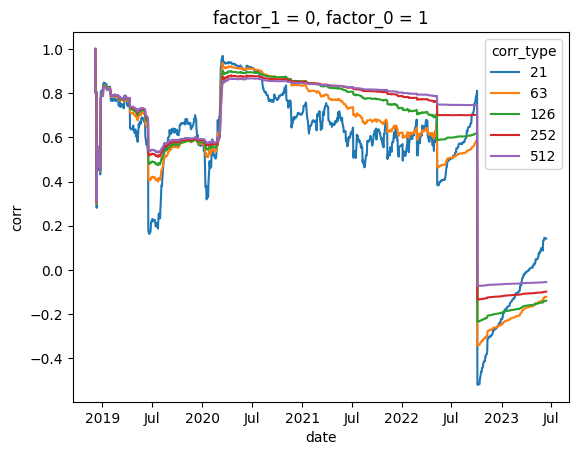

In [16]:
corr.sel(factor_1=0, factor_0=1).plot(hue="corr_type");

In [ ]:
corr.hvplot.image(by="corr_type", subplots=True, width=250, height=250, cmap="RdBu_r", clim=(-1, 1), colorbar=False).cols(2)

AttributeError: 'DataArray' object has no attribute 'hvplot'